In [1]:
# imports
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import time
from collections import defaultdict

/Users/HariRaval/miniconda3/envs/thesis/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# calculate du^ n / dt^n for arbitrary n and use this to create a loss term
def compute_derivative(u, t, norm_term, num_u_vectors):
    
    # compute derivative of outputs with respect to inputs 
    derivs_list = []
    for i in range(num_u_vectors):
        # individually compute du/dt for each u and combine them all togteher afterwards
        du_dt = torch.autograd.grad(u[:, i, :], t, grad_outputs=torch.ones_like(u[:, i, :]), create_graph=True)[0]
        derivs_list.append(du_dt)

    deriv_to_t = torch.stack(derivs_list, dim=1) 
    
    return deriv_to_t

# build the loss function
def loss(x, A, v, model):
    
    # loss results
    loss_dict = {}
            
    # create the trial solution
    model_result = lambda t: model(t)[0]
    u = model_result(x).unsqueeze(dim=-1)
    
    # determine the number of u vectors
    num_u_vectors = u.shape[1]
        
    # compute A * u
    A_times_u = torch.matmul(A, u)
    
    # compute du/dt (Note: each u is computed separately to avoid torch.autograd.grad() summing them together)
    du_dt = compute_derivative(u, x, 0, num_u_vectors)

    # compute the L_T term
    L_t_term = du_dt + A_times_u
    L_t = torch.matmul(L_t_term.mT, L_t_term)
    
    # compute the L_0 term
    u_0 = model_result(torch.tensor([[0]], dtype=torch.float32))[0].unsqueeze(dim=-1)
    L_0_term = u_0 - v
    L_0 = torch.matmul(L_0_term.T, L_0_term)
    
    # compute the overall loss 
    L = torch.mean(L_t) + L_0
    
    # normalize loss and use it to compute the normalization factor
    # norm_term1, norm_term2 = 1 / As[0] ** 2, 1 / As[1] ** 2 ---> these are now 1 / v[0] **2 (I.C.)
    
    loss_dict['L_D'] = L
    loss_dict['L_total'] = L

    return loss_dict


In [3]:
# class to build the network 
class BuildNetwork(nn.Module):
    def __init__(self, input_size, h_size1, h_size2, h_size3, output_size):
        super(BuildNetwork, self).__init__()
        self.l1 = nn.Linear(input_size, h_size1)
        self.tanh = nn.Tanh()
        self.l2 = nn.Linear(h_size1, h_size2)
        self.l3 = nn.Linear(h_size2, h_size3) # last hidden layer is 2d?
        self.output = nn.Linear(h_size3, output_size)
        
    def forward(self, x):
        result = self.l1(x)
        result = self.tanh(result)
        result = self.l2(result)
        result = self.tanh(result)
        result = self.l3(result) # make l3 of size 2d?
        h = self.tanh(result)
        result = self.output(h)
        
        return result, h

In [4]:
# train and evaluate the model
def run_model(iterations, x_range, A, v_list, hid_lay, num_equations, true_functs):
        
    assert num_equations > 0, 'The number of equations must be >= 1'
    
    # build the neural net model
    model = BuildNetwork(1, hid_lay[0], hid_lay[1], hid_lay[2], num_equations)
    # set-up the optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    # create a learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
    
    # extract the min and max range of x values to sample
    min_x, max_x = x_range
    
    # create a random number generator for loss computation
    rng = np.random.default_rng()
    
    # store loss and mse values
    loss_history = defaultdict(list)
    MSEs = []
    current_v_idx = -1
    
    start_time = time.time()
    
    for i in range(iterations):
        
        if i % 10000 == 0: 
            print(f"Iteration {i + 1} starting")
            current_v_idx += 1
            v = v_list[current_v_idx]
            print(v)
        
        # every batch, randomly sample from min and max range
        x = torch.arange(min_x, max_x, 0.001, requires_grad=True)
        x = x[rng.integers(low=0, high=len(x), size=500)]
        x = x.reshape(-1, 1)

        # forward: compute loss
        curr_loss = loss(x, A, v, model)
        
        # store individual loss terms for plotting
        loss_history['LD_losses'].append(curr_loss['L_D'].item())
        loss_history['Ltotal_losses'].append(curr_loss['L_total'].item())
            
        # backward: backpropagation
        curr_loss['L_total'].backward()
        
        # update weights and reset the gradients
        optimizer.step() 
        optimizer.zero_grad() 
        
        # learning rate update
        # scheduler.step()
        
        # compute the mse
        with torch.no_grad():
            current_mse = 0
            for i in range(num_equations):
                network_sol_i = model(x)[0][:, i].unsqueeze(dim=1).numpy()
                true_sol_i = true_functs[i](x)
                current_mse += np.mean((true_sol_i - network_sol_i) ** 2)
            MSEs.append(current_mse)
               
    end_time = time.time()
    total_time = end_time - start_time
    
    print(f"Model Training Complete in{total_time: .3f} seconds")
    
    return loss_history, model, total_time, MSEs

In [5]:
# function to plot the neural network vs exact solution
def plot_solution(x_range, true_functs, trained_model, axis):
    
    # function to extract the model results
    model_result = lambda t: trained_model(t)[0]
    
    # x values to predict on
    min_x, max_x = x_range
    xx = np.linspace(min_x, max_x, 200)[:, None]

    # find the model results
    u = model_result(torch.Tensor(xx))
    # determine the number of curves to plot
    num_curves = u.shape[1]
    # store the true solutions and network solutions
    yys, yts = [], []

    # save the network solutions in a list for plotting 
    with torch.no_grad():
        for i in range(num_curves):
            yys.append(u[:, i].numpy())
            yts.append(true_functs[i](xx))
    
    # plot the true solutions
    for i in range(num_curves):
         axis.plot(xx, yts[i], label=f'Actual Solution $u_{i+1}(t)$')
     
    # plot the network solutions
    for i in range(num_curves):
        axis.plot(xx, yys[i], '--', label=f'Neural Network Solution $u_{i+1}(t)$')
            
    axis.set_title("u(t) vs t for Actual and Approximation")
    axis.set_xlabel('$t$')
    axis.set_ylabel('$u(t)$')
    axis.legend(loc='best')
    
# function to plot the overall loss of the network solution
def plot_total_loss(iterations, train_losses, axis, loss_label):
    axis.plot(range(iterations), train_losses, label=loss_label)
    axis.set_yscale("log")
    axis.set_title("Total Loss vs Iterations")
    axis.set_xlabel('Iterations')
    axis.set_ylabel('Loss')
    axis.legend(loc='best')
    
# function to plot the MSEs
def plot_mse(iterations, mses, axis):
    axis.plot(range(iterations), mses, label='MSE')
    axis.set_yscale("log")
    axis.set_title("MSE vs Iterations")
    axis.set_xlabel('Iterations')
    axis.set_ylabel('MSE')
    axis.legend(loc='best')
    
# wrapper function to plot the solution and the overall loss & MSE of the network solution
def plot_loss_mse_and_solution(x_range, true_functs, iterations, trained_model, train_losses, 
                               loss_label, mses):
    
    fig, axs = plt.subplots(1, 3,  tight_layout=True, figsize=(24, 8))
    
    plot_total_loss(iterations=iterations, train_losses=train_losses, 
                    axis=axs[0], loss_label=loss_label)
    plot_solution(x_range=x_range, true_functs=true_functs, 
                  trained_model=trained_model, axis=axs[1])
    plot_mse(iterations=iterations, mses=mses, axis=axs[2])
    
    plt.show()

In [6]:
# set-up differential equation parameters for network
x_range = [0, 2]
# A = torch.tensor([[1.1, 0], [0, 3]]) # non-coupled equations
A = torch.tensor([[0, 1.1], [1.1, 0]])
v_list = [torch.tensor([[0.12], [0.35]]), torch.tensor([[0.87], [0.62]]), 
          torch.tensor([[0.34], [0.69]]), torch.tensor([[0.75], [0.25]])]
hid_lay = [64, 64, 64]
num_equations, iterations = 2, 40000

# write actual solutions for computing MSE and plotting true solution
v = v_list[3]
true_f1 = lambda x: (0.5 * v[0] * np.exp(-1.1 * x) * (np.exp(2.2 * x) + 1) - (0.5 * v[1] * np.exp(-1.1 * x) * (np.exp(2.2 * x) - 1))).numpy()
true_f2 = lambda x: (0.5 * v[1] * np.exp(-1.1 * x) * (np.exp(2.2 * x) + 1) - (0.5 * v[0] * np.exp(-1.1 * x) * (np.exp(2.2 * x) - 1))).numpy()
true_functs = [true_f1, true_f2]


Iteration 1 starting
tensor([[0.1200],
        [0.3500]])
Iteration 10001 starting
tensor([[0.8700],
        [0.6200]])
Iteration 20001 starting
tensor([[0.3400],
        [0.6900]])
Iteration 30001 starting
tensor([[0.7500],
        [0.2500]])
Model Training Complete in 145.545 seconds


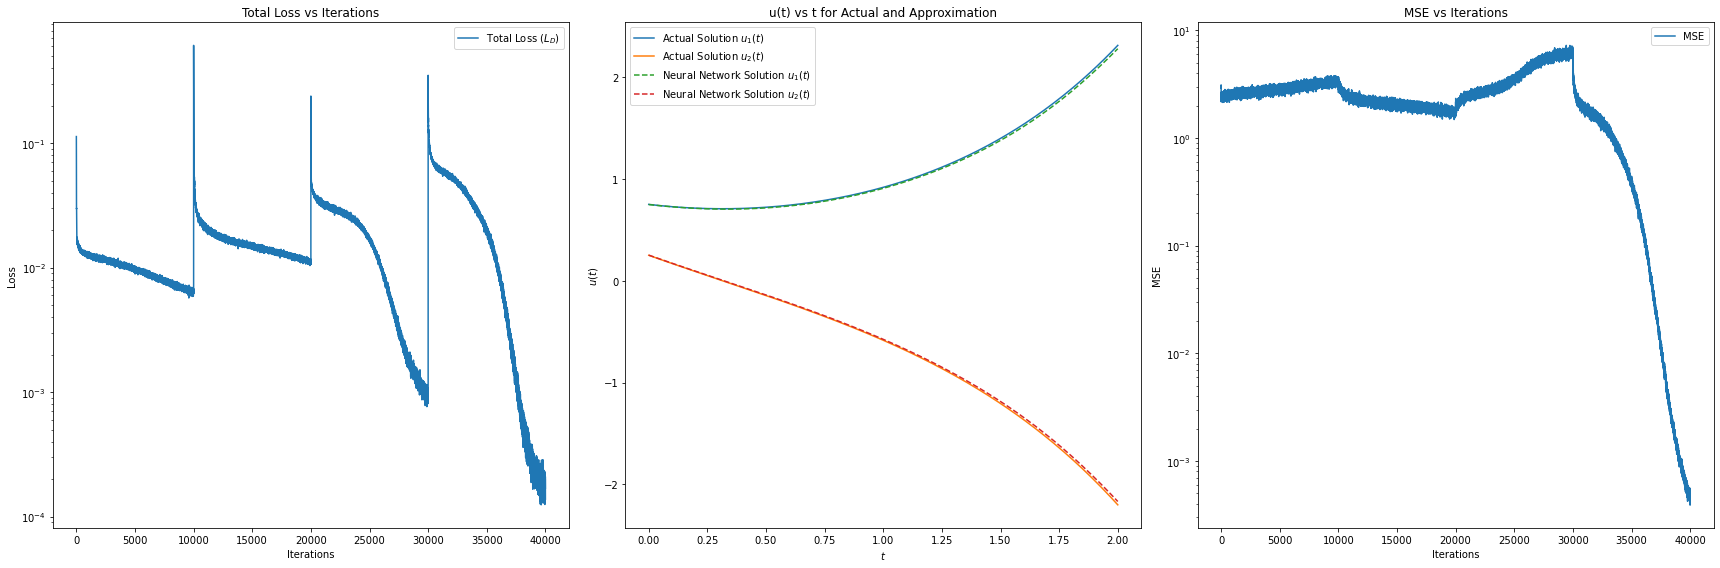

In [7]:
if True:
    # run model which has a loss of the MSE (i.e. no higher order terms)
    loss_history_w1, trained_model_w1, time_w1, MSE_w1 = run_model(iterations=iterations, x_range=x_range, 
                                                                   A=A, v_list=v_list, hid_lay=hid_lay,
                                                                   num_equations=num_equations, 
                                                                   true_functs=true_functs)

    # plot the total loss, network vs true solution, and MSE
    plot_loss_mse_and_solution(x_range=x_range, true_functs=true_functs, iterations=iterations, 
                               trained_model=trained_model_w1, 
                               train_losses=loss_history_w1['Ltotal_losses'], 
                               loss_label='Total Loss ($L_D$)', mses=MSE_w1)

#     save the model 
#     torch.save(trained_model_w1, "./trained_model_40000.pt")

# Sanity Check Formula Construction

In [8]:
rng = np.random.default_rng()
t_eval = torch.arange(0, 2, 0.001, requires_grad=True)
t_eval = t_eval[rng.integers(low=0, high=2000, size=500)]
t_eval = t_eval.reshape(-1, 1)

# forward pass to extract H 
output, H = trained_model_w1(t_eval) 
H = H.reshape(-1, num_equations, hid_lay[-1] // num_equations)
H = torch.cat((torch.ones(len(t_eval), num_equations, 1), H), 2)
dH_dt_old = torch.autograd.functional.jacobian(trained_model_w1, t_eval, create_graph=True)[1].sum(axis=2)

In [9]:
dH_dt_old2 = dH_dt_old.reshape(-1, num_equations, hid_lay[-1] // num_equations)
dH_dt_old2 = torch.cat((torch.zeros(len(t_eval), num_equations, 1), dH_dt_old2), 2)

In [10]:
dH_dt_times_dH_dt_T = torch.matmul(dH_dt_old2.mT, dH_dt_old2)
print("dH_dt_times_dH_dt_T shape: ", dH_dt_times_dH_dt_T.shape)

dH_dt_times_A_times_H = torch.matmul(torch.matmul(dH_dt_old2.mT, A), H)
print("dH_dt_times_A_times_H shape: ", dH_dt_times_A_times_H.shape)

H_times_A_T_times_dH_dt = torch.matmul(torch.matmul(H.mT, A.T), dH_dt_old2)
print("dH_dt_times_A_times_H shape: ", H_times_A_T_times_dH_dt.shape)

H_T_times_A_T_times_A_times_H = torch.matmul(torch.matmul(torch.matmul(H.mT, A.T), A), H)
print("H_T_times_A_T_times_A_times_H shape: ", H_T_times_A_T_times_A_times_H.shape)

M = dH_dt_times_dH_dt_T + dH_dt_times_A_times_H + H_times_A_T_times_dH_dt + H_T_times_A_T_times_A_times_H
M = M.sum(axis=0)
M = M / len(t_eval)
print("M matrix shape: ", M.shape)

output_0, H_0 = trained_model_w1(torch.tensor([[0.]], dtype=torch.float32, requires_grad=True))
H_0 = H_0.reshape(-1, num_equations, hid_lay[-1] // num_equations)
H_0 = torch.cat((torch.ones(1, num_equations, 1), H_0), 2).squeeze()
H_0_T_times_H_0 = torch.matmul(H_0.mT, H_0)

M += H_0_T_times_H_0
M_inv = torch.linalg.pinv(M)

W_out = torch.matmul(torch.matmul(M_inv, H_0.T), v)

print("W_out shape: ", W_out.shape)

# u = H * W_o

dH_dt_times_dH_dt_T shape:  torch.Size([500, 33, 33])
dH_dt_times_A_times_H shape:  torch.Size([500, 33, 33])
dH_dt_times_A_times_H shape:  torch.Size([500, 33, 33])
H_T_times_A_T_times_A_times_H shape:  torch.Size([500, 33, 33])
M matrix shape:  torch.Size([33, 33])
W_out shape:  torch.Size([33, 1])


In [11]:
# dH_dt = torch.cat((torch.zeros(len(t_eval), 1, 1), dH_dt_old), 1)
bias = list(trained_model_w1.parameters())[-1].unsqueeze(dim=-1).T
w_r = list(trained_model_w1.parameters())[-2].detach().T
w_r_new = torch.cat((bias, w_r), 0).T

In [ ]:
# # compute dH_dt times dH_dt transpose and sum across time
# dH_dt_times_dH_dt_T = (torch.matmul(dH_dt, dH_dt.mT).sum(axis=0)) / len(t_eval)
# first_term = torch.matmul(w_r_new, dH_dt_times_dH_dt_T)

# # compute dH_dt times H transpose and sum across time
# new_H = torch.unsqueeze(H, dim=-1)
# dH_dt_times_H_T = (torch.matmul(dH_dt, new_H.mT).sum(axis=0)) / len(t_eval)
# second_term = torch.matmul(A.T, w_r_new)
# second_term = torch.matmul(second_term, dH_dt_times_H_T)

# # compute H times dH_dt transpose and sum across time
# H_times_dH_dt_T = (torch.matmul(new_H, dH_dt.mT).sum(axis=0)) / len(t_eval)
# third_term = torch.matmul(A, w_r_new)
# third_term = torch.matmul(third_term, H_times_dH_dt_T)

# # compute H times H transpose and sum across time
# H_times_H_T = (torch.matmul(new_H, new_H.mT).sum(axis=0)) / len(t_eval)
# fourth_term = torch.matmul(A.T, A)
# fourth_term = torch.matmul(fourth_term, w_r_new)
# fourth_term = torch.matmul(fourth_term, H_times_H_T)

# # compute H_0 times H_0 transpose
# output_0, H_0 = trained_model_w1(torch.tensor([[0.]], dtype=torch.float32, requires_grad=True))
# H_0 = torch.cat((torch.ones(1, 1), H_0), 1)
# H_0_T_times_H_0 = torch.matmul(H_0.T, H_0)
# fifth_term = torch.matmul(w_r_new, H_0_T_times_H_0)

# RHS = torch.matmul(v, H_0) - fifth_term
# LHS = first_term + second_term + third_term + fourth_term

# loss_vals_to_plot = (LHS - RHS).detach().numpy().reshape(-1, 1)
# plt.hist(loss_vals_to_plot);
# plt.title("Check Original Equation")
# plt.xlabel("Loss")
# plt.ylabel("Frequency");

# Oracle Approach to Find W

In [ ]:
# this happened to work one time, but ONLY with pinv and not when we combine the sums and divisions
summ_term = (torch.matmul(dH_dt, dH_dt.mT).sum(axis=0)) / 500 + \
(torch.matmul(dH_dt, new_H.mT).sum(axis=0)) / 500 + \
(torch.matmul(new_H, dH_dt.mT).sum(axis=0)) / 500 + \
(torch.matmul(new_H, new_H.mT).sum(axis=0)) / 500 + torch.matmul(H_0.T, H_0)

# summ_term = summ_term.sum(axis=0)
# summ_term = summ_term / len(t_eval)
summ_term = torch.linalg.pinv(summ_term)
W_oracle2 = torch.matmul(torch.matmul(v, H_0), summ_term)
W_oracle2

In [17]:
print(res[:, 0].shape)
print(res[:, 1].shape)

torch.Size([500])
torch.Size([500])


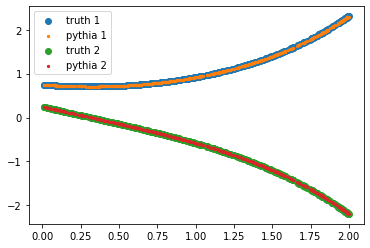

In [19]:
# U = H * W_0
res = torch.matmul(H, W_out).squeeze()
plt.scatter(t_eval.detach().numpy(), true_f1(t_eval.detach().numpy()), label= 'truth 1');
plt.scatter(t_eval.detach().numpy(), res[:, 0].detach().numpy(), label='pythia 1', s=5);
plt.scatter(t_eval.detach().numpy(), true_f2(t_eval.detach().numpy()), label= 'truth 2');
plt.scatter(t_eval.detach().numpy(), res[:, 1].detach().numpy(), label='pythia 2', s=5);
plt.legend();